In [1]:
import pickle
import random
import gym
import gym.spaces
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from gym.envs.registration import register

register(
    id='AppEnvironment-v0',
    entry_point='RLSimulation:AppEnvironment',
)

In [2]:
def pad_with_nan(lst=[], n=20):
  return lst[:n] +[-1.0]* (n-len(lst))

In [3]:
def generate_performance_score(timeSpentOnTasks, benchmarkTasks, taskCategories, catWeights=[0.1, 0.2, 0.3, 0.4]):
        model_default = pickle.load(open('modelp.pkl', 'rb'))

        dataset = np.array([])
        for i in range(len(timeSpentOnTasks)):
            encodedTaskCategory = np.zeros(20)
            encodedTaskCategory[int(taskCategories[i])] = 1
            dataset = np.append(dataset, [timeSpentOnTasks[i]])
            dataset = np.append(dataset, [benchmarkTasks[i]])
            dataset = np.append(dataset, encodedTaskCategory)
            dataset = np.append(dataset, catWeights[int(taskCategories[i])])
        
#        dataset = np.pad(dataset, (0, 80-len(dataset)), 'constant', constant_values=(-1))
     
     
        
        res = model_default.predict([dataset]).astype(int)[0]
        return max(1, min(100,res)) # Make a prediction

        

In [4]:

#GLOABL VARIABLES

numTasks = 20
numCategories = 4
benchmarkTasks = pad_with_nan([round(random.uniform(0.1,3),1) for i in range(numTasks)])
taskCategories = pad_with_nan([random.randint(0, numCategories-1) for i in range(numTasks)])
catWeights = [0.1, 0.2, 0.3, 0.4]

class AppEnvironment(gym.Env):

    def __init__(self):

        #time spent on task i, benchmark task i, task category i
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(numTasks+1,), dtype=float)
        
        #3 Step: Define category weights
        #catWeights = [0.1, 0.2, 0.3, 0.4]
        #4 Step: Define benchmark time and category for each task
        timeSpentOnTasks = [0 for i in range(numTasks)]

        timeSpentOnTasks = pad_with_nan(timeSpentOnTasks)
    

        self.observation = np.array(timeSpentOnTasks + [float(generate_performance_score(timeSpentOnTasks, benchmarkTasks, taskCategories))])
        #print(self.observation.shape)
        self.action_space = gym.spaces.Discrete(20*6)
        #what can the agent do?
        #0 - complete task i in benchmark time
        #1 - complete task i in 3/4 benchmark time
        #2 - complete task i in 1/2 benchmark time
        #3 - complete task i in 5/4 benchmark time
        #4 - complete task i in 3/2 benchmark time
        #5 - complete task i in 2x benchmark time



    
    def reset(self):
        #time spent on task i, benchmark task i, task category i
        timeSpentOnTasks = [0 for i in range(numTasks)]
        timeSpentOnTasks = pad_with_nan(timeSpentOnTasks)
        
        self.observation = np.array(timeSpentOnTasks + [float(generate_performance_score(timeSpentOnTasks, benchmarkTasks, taskCategories))])
        return self.observation

    def step(self, action):
        # Update the state based on the action
        new_obersevation = self.observation.copy()
        done = False
        reward = 0


        #if the tasks has alread been done, do not do it again
        if new_obersevation[action // 6] != 0:
            reward = -1000
            


        taskInQuestion = int(action / 6)
        speedChoice = (action % 6)

        if speedChoice == 0:
            new_obersevation[taskInQuestion] = benchmarkTasks[taskInQuestion]
        elif speedChoice == 1:
            new_obersevation[taskInQuestion] = benchmarkTasks[taskInQuestion] * 3/4
        elif speedChoice == 2:
            new_obersevation[taskInQuestion] = benchmarkTasks[taskInQuestion] * 1/2
        elif speedChoice == 3:
            new_obersevation[taskInQuestion] = benchmarkTasks[taskInQuestion] * 5/4
        elif speedChoice == 4:
            new_obersevation[taskInQuestion] = benchmarkTasks[taskInQuestion] * 3/2
        elif speedChoice == 5:
            new_obersevation[taskInQuestion] = benchmarkTasks[taskInQuestion] * 2

        
        self.observation = new_obersevation

        new_performance = generate_performance_score(self.observation[:20], 
                                                     benchmarkTasks, 
                                                    taskCategories, 
                                                    )
                                            
        reward -= 100 if new_performance <= self.observation[20] else new_performance - self.observation[20]


        
        #all tasks done badly... end the game
        if (all([v!=0 for v in new_obersevation[:20]]) and new_performance <= 95):
            reward -= 1000
            done = True
            

        #print("Action: ", action, "Obersevation: ", new_obersevation)
        
        
        self.observation[20] = new_performance

        if new_performance > 90:
            done = True
            #print("Performance is greater than 95")
            reward += 1000

        #print("Action: ", action, "Obersevation: ", self.observation, "Reward: ", reward, "Done: ", done)

        info = {}
        return self.observation, reward, done, info

In [5]:
environment = AppEnvironment()
model = PPO('MlpPolicy', env=environment,verbose=1)

model.learn(total_timesteps=30000, progress_bar=True)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/andrei/ETH/wunderkind/WunderkindBackend/.venv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Output()

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 41.5      |
|    ep_rew_mean     | -2.85e+04 |
| time/              |           |
|    fps             | 68        |
|    iterations      | 1         |
|    time_elapsed    | 29        |
|    total_timesteps | 2048      |
----------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 43.1         |
|    ep_rew_mean          | -2.96e+04    |
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 2            |
|    time_elapsed         | 81           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 9.168347e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.79        |
|    explained_variance   | 2.68e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.98e+07     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000511    |
|    value_loss           | 1.14e+08     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 45.4         |
|    ep_rew_mean          | -3.16e+04    |
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3            |
|    time_elapsed         | 132          |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 7.923169e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.79        |
|    explained_variance   | -2.38e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 5.02e+07     |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.000468    |
|    value_loss           | 1.08e+08     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 44           |
|    ep_rew_mean          | -3.02e+04    |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 4            |
|    time_elapsed         | 184          |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 7.864583e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.79        |
|    explained_variance   | 2.74e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.23e+07     |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00052     |
|    value_loss           | 1.18e+08     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 39.6          |
|    ep_rew_mean          | -2.65e+04     |
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 5             |
|    time_elapsed         | 236           |
|    total_timesteps      | 10240         |
| train/                  |               |
|    approx_kl            | 1.0858406e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.79         |
|    explained_variance   | 3.22e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 5.09e+07      |
|    n_updates            | 40            |
|    policy_gradient_loss | -0.000626     |
|    value_loss           | 1.07e+08      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 40.3         |
|    ep_rew_mean          | -2.69e+04    |
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 6            |
|    time_elapsed         | 289          |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 9.072828e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.79        |
|    explained_variance   | 1.91e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.24e+07     |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.000522    |
|    value_loss           | 1.1e+08      |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 38.2          |
|    ep_rew_mean          | -2.46e+04     |
| time/                   |               |
|    fps                  | 41            |
|    iterations           | 7             |
|    time_elapsed         | 341           |
|    total_timesteps      | 14336         |
| train/                  |               |
|    approx_kl            | 1.0505144e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.79         |
|    explained_variance   | 7.15e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 5.44e+07      |
|    n_updates            | 60            |
|    policy_gradient_loss | -0.000567     |
|    value_loss           | 9.82e+07      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 37.1          |
|    ep_rew_mean          | -2.41e+04     |
| time/                   |               |
|    fps                  | 41            |
|    iterations           | 8             |
|    time_elapsed         | 395           |
|    total_timesteps      | 16384         |
| train/                  |               |
|    approx_kl            | 1.4605117e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.79         |
|    explained_variance   | 8.34e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 3.66e+07      |
|    n_updates            | 70            |
|    policy_gradient_loss | -0.00077      |
|    value_loss           | 8.93e+07      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 39.9          |
|    ep_rew_mean          | -2.67e+04     |
| time/                   |               |
|    fps                  | 41            |
|    iterations           | 9             |
|    time_elapsed         | 446           |
|    total_timesteps      | 18432         |
| train/                  |               |
|    approx_kl            | 1.2045086e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.79         |
|    explained_variance   | 7.15e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 4.86e+07      |
|    n_updates            | 80            |
|    policy_gradient_loss | -0.000708     |
|    value_loss           | 1.08e+08      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 41.9          |
|    ep_rew_mean          | -2.81e+04     |
| time/                   |               |
|    fps                  | 41            |
|    iterations           | 10            |
|    time_elapsed         | 498           |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 1.1522934e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.79         |
|    explained_variance   | 5.96e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 5.5e+07       |
|    n_updates            | 90            |
|    policy_gradient_loss | -0.000647     |
|    value_loss           | 1.08e+08      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 46.1         |
|    ep_rew_mean          | -3.21e+04    |
| time/                   |              |
|    fps                  | 40           |
|    iterations           | 11           |
|    time_elapsed         | 550          |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 8.941366e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.79        |
|    explained_variance   | 7.15e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.23e+07     |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00052     |
|    value_loss           | 1.06e+08     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 44.4         |
|    ep_rew_mean          | -3.09e+04    |
| time/                   |              |
|    fps                  | 40           |
|    iterations           | 12           |
|    time_elapsed         | 605          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 8.438918e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.79        |
|    explained_variance   | 4.77e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.35e+07     |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.000517    |
|    value_loss           | 1.25e+08     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 36            |
|    ep_rew_mean          | -2.28e+04     |
| time/                   |               |
|    fps                  | 40            |
|    iterations           | 13            |
|    time_elapsed         | 660           |
|    total_timesteps      | 26624         |
| train/                  |               |
|    approx_kl            | 9.6158765e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.79         |
|    explained_variance   | 1.79e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 5.02e+07      |
|    n_updates            | 120           |
|    policy_gradient_loss | -0.00055      |
|    value_loss           | 1.05e+08      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 34.8          |
|    ep_rew_mean          | -2.19e+04     |
| time/                   |               |
|    fps                  | 39            |
|    iterations           | 14            |
|    time_elapsed         | 720           |
|    total_timesteps      | 28672         |
| train/                  |               |
|    approx_kl            | 1.7076469e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.79         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 3.41e+07      |
|    n_updates            | 130           |
|    policy_gradient_loss | -0.000825     |
|    value_loss           | 8.09e+07      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 37.9          |
|    ep_rew_mean          | -2.46e+04     |
| time/                   |               |
|    fps                  | 39            |
|    iterations           | 15            |
|    time_elapsed         | 774           |
|    total_timesteps      | 30720         |
| train/                  |               |
|    approx_kl            | 1.0851043e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.79         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 5.2e+07       |
|    n_updates            | 140           |
|    policy_gradient_loss | -0.000572     |
|    value_loss           | 1.02e+08      |
-------------------------------------------


## Evaluate the model

In [6]:
eval_env = AppEnvironment()
#mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=1, deterministic=False)
#print(f"Mean reward: {mean_reward} +/- {std_reward}")

## Simulating the Environment

In [21]:
performance_score=[]

mean_finish_time = 0

for i in range(100):
    tmp_arr = []
    obs = eval_env.reset()
    for j in range(200):
        # Best Suggestions
        action, _states = model.predict(obs)
        #print("suggesting: ", action//6, " with speed: ", action%6)
        # Child will sometimes consider suggestions of app or not
        action = random.randint(1,24)*5-1 if random.random() < 0.25 else action

        tmpobs = obs.copy()
        obs, rewards, dones, info = eval_env.step(action)

        if(len([v for v in obs[:20] if v != 0]) == len([v for v in tmpobs[:20] if v != 0])):
            #print("Same task done twice")
            obs = tmpobs

        #print("Observation: ", obs, "Reward: ", rewards, "Done: ", dones)
        tmp_arr.append(obs[20])
        if dones:
            print("Episode finished after {} timesteps".format(j+1))
            break
    mean_finish_time += j+1
    performance_score.append(tmp_arr)
print("Mean finish time: ", mean_finish_time/100)

Episode finished after 75 timesteps
Episode finished after 48 timesteps
Episode finished after 21 timesteps
Episode finished after 40 timesteps
Episode finished after 53 timesteps
Episode finished after 55 timesteps
Episode finished after 36 timesteps
Episode finished after 79 timesteps
Episode finished after 42 timesteps
Episode finished after 21 timesteps
Episode finished after 20 timesteps
Episode finished after 30 timesteps
Episode finished after 56 timesteps
Episode finished after 22 timesteps
Episode finished after 15 timesteps
Episode finished after 26 timesteps
Episode finished after 16 timesteps
Episode finished after 7 timesteps
Episode finished after 22 timesteps
Episode finished after 73 timesteps
Episode finished after 20 timesteps
Episode finished after 67 timesteps
Episode finished after 23 timesteps
Episode finished after 32 timesteps
Episode finished after 26 timesteps
Episode finished after 30 timesteps
Episode finished after 78 timesteps
Episode finished after 46 tim

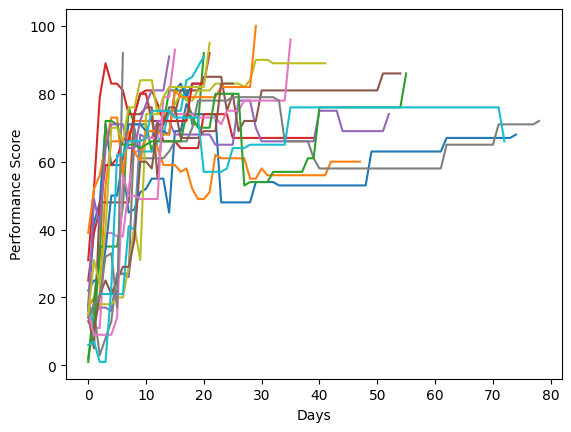

In [28]:
for i in range(10):
    plt.plot(performance_score[i])
plt.ylabel('Performance Score')
plt.xlabel('Days')
plt.show()
